In [1]:
import multiprocessing as mp
import parmap
import sys, os
import pandas as pd
import gzip

## List of inputs
# ref = pd.read_csv(snakemake.input.merge_table, compression="gzip", sep="\t")
ref = pd.read_csv("/scratch/tweber/DATA/1000G_SNV_with_GT/OTF/OTF/BCFTOOLS_CONCAT_TAB/merge.txt.gz", compression="gzip", sep="\t")
ref

/g/korbel2/weber/miniconda3/envs/mosaicatcher_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,ID,AC,AF,SAMPLE
0,10:18542:G:A,53,0.008276,NA10864
1,10:28524:C:T,106,0.016552,NA10864
2,10:36228:G:T,2,0.000312,NA10864
3,10:36229:G:A,2,0.000312,NA10864
4,10:47041:C:T,45,0.007027,NA10864
...,...,...,...,...
17317051,X:156022561:C:T,219,0.034197,HG04157
17317052,X:156028529:C:T,80,0.012492,HG04157
17317053,X:156028841:C:G,98,0.015303,HG04157
17317054,X:156028858:G:A,75,0.011711,HG04157


In [2]:
ref.ID.nunique()

10261824

In [3]:
ref.SAMPLE.nunique()

40

In [2]:
m = mp.Manager()
l_df_gb = m.list()
l_df = m.list()

def mp_vcf(vcf, l_df_gb, l_df):

    # Nb of rows to skip at the beginning of the VCF
    skip = len([e.decode("ISO-8859–1").split('\n') for e in gzip.open("{}".format(f + vcf, "rb")) if e.decode("ISO-8859–1").split('\n')[0].startswith("##")])
    # chrom = vcf.split("/")[-3]
    sample = vcf.replace(".vcf.gz", "")
    df = pd.read_csv(f + vcf, compression="gzip", skiprows=skip, sep="\t")
    df["#CHROM"] = df["#CHROM"].astype(str)
    df["#CHROM"] = df["#CHROM"].str.replace("chr", "")
    df["ID"] = df["#CHROM"].astype(str) + ":" + df["POS"].astype(str) + ":" + df["REF"] + ":" + df["ALT"]

    # df = df.loc[df["QUAL"] >= 10]

    merge_df = pd.merge(ref, df, on="ID", how='right')

    merge_df["SAMPLE"] = merge_df["SAMPLE"].fillna("NAN")
    merge_df["QUERY_SAMPLE_CELL"] = sample
    

    merge_df_gb = merge_df.groupby("SAMPLE")["ID"].nunique().sort_values(ascending=False).reset_index()
    merge_df_gb["QUERY_SAMPLE_CELL"] = sample
    merge_df_gb["Rank"] = list(range(1,1+merge_df_gb.shape[0]))
    merge_df_gb["Total_SNP"] = df.shape[0]

    l_df_gb.append(merge_df_gb)
    l_df.append(merge_df)
# f = snakemake.input.gt_sample_folder
f = "/scratch/tweber/DATA/1000G_SNV_with_GT/OTF/GENOTYPING_OTF_POOL1/"
f_ldir = sorted([e for e in os.listdir(f) if e.endswith(".vcf.gz")])
parmap.starmap(mp_vcf, list(zip(f_ldir)), l_df_gb, l_df)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [3]:
pd.options.display.max_rows = 250
concat_df = pd.concat(list(l_df))
concat_df

,ID,AC,AF,SAMPLE,#CHROM,POS,REF,ALT,QUAL,FILTER,INFO,FORMAT,HGSVCxPool1,QUERY_SAMPLE_CELL
0,13:112035408:G:C,16.0,0.002498,NA20128,13,112035408,G,C,0.038755,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:0.00765515:2:1,1:1:32:1:14",HGSVCPool1x02PE20320
1,13:112035408:G:C,16.0,0.002498,HG02978,13,112035408,G,C,0.038755,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:0.00765515:2:1,1:1:32:1:14",HGSVCPool1x02PE20320
2,13:113367964:T:C,13.0,0.002030,NA20510,13,113367964,T,C,2.20804,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:0.664304:2:1,1:1:36:1:32",HGSVCPool1x02PE20320
3,18:35818445:G:T,6.0,0.000937,HG03771,18,35818445,G,T,4.18231,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:1.17201:2:1,1:1:36:1:36",HGSVCPool1x02PE20320
4,19:54413419:A:T,88.0,0.013741,NA18530,19,54413419,A,T,4.18231,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:1.17201:2:1,1:1:36:1:36",HGSVCPool1x02PE20320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,8:86614357:T:C,146.0,0.022798,HG02615,8,86614357,T,C,4.18231,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:1.17201:2:1,1:1:36:1:36",HGSVCPool1x02PE20314
21,8:86614357:T:C,146.0,0.022798,HG02812,8,86614357,T,C,4.18231,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:1.17201:2:1,1:1:36:1:36",HGSVCPool1x02PE20314
22,8:86614357:T:C,146.0,0.022798,HG03098,8,86614357,T,C,4.18231,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:1.17201:2:1,1:1:36:1:36",HGSVCPool1x02PE20314
23,8:86614357:T:C,146.0,0.022798,HG03480,8,86614357,T,C,4.18231,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:1.17201:2:1,1:1:36:1:36",HGSVCPool1x02PE20314


In [4]:
# concat_counts_df = concat_df.loc[concat_df["QUAL"] >= 10].groupby("QUERY_SAMPLE_CELL")["SAMPLE"].value_counts().rename("Counts").reset_index()
concat_counts_df = concat_df.groupby("QUERY_SAMPLE_CELL")["SAMPLE"].value_counts().rename("Counts").reset_index()
concat_counts_df["Rank"] = concat_counts_df.groupby("QUERY_SAMPLE_CELL")["SAMPLE"].transform(lambda r: range(1, len(r) + 1))
concat_counts_df

,QUERY_SAMPLE_CELL,SAMPLE,Counts,Rank
0,HGSVCPool1x02PE20302,NA19436,5,1
1,HGSVCPool1x02PE20302,HG04115,4,2
2,HGSVCPool1x02PE20302,HG02945,3,3
3,HGSVCPool1x02PE20302,HG00179,1,4
4,HGSVCPool1x02PE20302,HG01881,1,5
...,...,...,...,...
1213,HGSVCPool1x02PE20396,NA20869,7,37
1214,HGSVCPool1x02PE20396,HG02662,5,38
1215,HGSVCPool1x02PE20396,HG03771,5,39
1216,HGSVCPool1x02PE20396,HG04157,5,40


In [7]:
# coverage_df = pd.read_csv(snakemake.input.coverage, sep="\t")
coverage_df = pd.read_csv("/scratch/tweber/DATA/1000G_SNV_with_GT/OTF/COVERAGE/HGSVCxPool1/MERGE/merge_coverage.txt", sep="\t")
coverage_df

,QUERY_SAMPLE_CELL,meandepth
0,HGSVCPool1x02PE20301,0.000085
1,HGSVCPool1x02PE20302,0.005977
2,HGSVCPool1x02PE20303,0.003316
3,HGSVCPool1x02PE20304,0.001982
4,HGSVCPool1x02PE20305,0.001252
5,HGSVCPool1x02PE20306,0.001368
6,HGSVCPool1x02PE20307,0.007698
7,HGSVCPool1x02PE20308,0.001475
8,HGSVCPool1x02PE20309,0.011717
9,HGSVCPool1x02PE20310,0.004760


In [9]:
# ashleys_predictions = pd.read_csv(snakemake.input.labels, sep="\t").rename({"cell": "QUERY_SAMPLE_CELL", "prediction" : "ashleys_prediction", "probability": "ashleys_probability"}, axis=1).sort_values(by="QUERY_SAMPLE_CELL")
ashleys_predictions = pd.read_csv("/g/korbel2/weber/MosaiCatcher_files/POOLING/POOL1_RESEQ/HGSVCxPool1/cell_selection/labels.tsv", sep="\t").rename({"cell": "QUERY_SAMPLE_CELL", "prediction" : "ashleys_prediction", "probability": "ashleys_probability"}, axis=1).sort_values(by="QUERY_SAMPLE_CELL")
ashleys_predictions["QUERY_SAMPLE_CELL"] = ashleys_predictions["QUERY_SAMPLE_CELL"].str.replace(".sort.mdup.bam", "")
mc_predictions = pd.read_csv("/g/korbel2/weber/MosaiCatcher_files/POOLING/POOL1_RESEQ/HGSVCxPool1/counts/HGSVCxPool1.info_raw", skiprows=13, sep="\t").rename({"cell": "QUERY_SAMPLE_CELL"}, axis=1)[["QUERY_SAMPLE_CELL", "mapped", "good", "pass1"]].rename({"mapped": "reads_mapped", "good" : "reads_used", "pass1": "mc_coverage_compliant"}, axis=1)
# mc_predictions = pd.read_csv(snakemake.input.info_raw, skiprows=13, sep="\t").rename({"cell": "QUERY_SAMPLE_CELL"}, axis=1)[["QUERY_SAMPLE_CELL", "mapped", "good", "pass1"]].rename({"mapped": "reads_mapped", "good" : "reads_used", "pass1": "mc_coverage_compliant"}, axis=1)
ashleys_mc_predictions = pd.merge(
    ashleys_predictions,
    mc_predictions,
    on="QUERY_SAMPLE_CELL"
)
ashleys_mc_predictions.loc[(ashleys_mc_predictions["ashleys_prediction"] == 1) & (ashleys_mc_predictions["mc_coverage_compliant"] == 1), "Used/Not used in MC"] = 1
ashleys_mc_predictions["Used/Not used in MC"] = ashleys_mc_predictions["Used/Not used in MC"].fillna(0)
ashleys_mc_predictions["Used/Not used in MC"] = ashleys_mc_predictions["Used/Not used in MC"].astype(int)
ashleys_mc_predictions

/tmp/ipykernel_128389/549587879.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  ashleys_predictions["QUERY_SAMPLE_CELL"] = ashleys_predictions["QUERY_SAMPLE_CELL"].str.replace(".sort.mdup.bam", "")


,QUERY_SAMPLE_CELL,ashleys_prediction,ashleys_probability,reads_mapped,reads_used,mc_coverage_compliant,Used/Not used in MC
0,HGSVCPool1x02PE20301,0,0.0000,6305,1400,0,0
1,HGSVCPool1x02PE20302,1,0.7984,1049263,93024,1,1
2,HGSVCPool1x02PE20303,0,0.0181,499590,49253,0,0
3,HGSVCPool1x02PE20304,0,0.0000,334000,33139,0,0
4,HGSVCPool1x02PE20305,0,0.0000,207771,19169,0,0
5,HGSVCPool1x02PE20306,0,0.0000,231964,23091,0,0
6,HGSVCPool1x02PE20307,1,0.7895,1427076,122780,1,1
7,HGSVCPool1x02PE20308,0,0.0000,243063,24729,0,0
8,HGSVCPool1x02PE20309,1,0.9334,1878930,178861,1,1
9,HGSVCPool1x02PE20310,0,0.1676,850784,76733,1,0


In [15]:
concat_df

,ID,AC,AF,SAMPLE,#CHROM,POS,REF,ALT,QUAL,FILTER,INFO,FORMAT,HGSVCxPool1,QUERY_SAMPLE_CELL
0,13:112035408:G:C,16.0,0.002498,NA20128,13,112035408,G,C,0.038755,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:0.00765515:2:1,1:1:32:1:14",HGSVCPool1x02PE20320
1,13:112035408:G:C,16.0,0.002498,HG02978,13,112035408,G,C,0.038755,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:0.00765515:2:1,1:1:32:1:14",HGSVCPool1x02PE20320
2,13:113367964:T:C,13.0,0.002030,NA20510,13,113367964,T,C,2.20804,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:0.664304:2:1,1:1:36:1:32",HGSVCPool1x02PE20320
3,18:35818445:G:T,6.0,0.000937,HG03771,18,35818445,G,T,4.18231,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:1.17201:2:1,1:1:36:1:36",HGSVCPool1x02PE20320
4,19:54413419:A:T,88.0,0.013741,NA18530,19,54413419,A,T,4.18231,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:1.17201:2:1,1:1:36:1:36",HGSVCPool1x02PE20320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,8:86614357:T:C,146.0,0.022798,HG02615,8,86614357,T,C,4.18231,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:1.17201:2:1,1:1:36:1:36",HGSVCPool1x02PE20314
21,8:86614357:T:C,146.0,0.022798,HG02812,8,86614357,T,C,4.18231,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:1.17201:2:1,1:1:36:1:36",HGSVCPool1x02PE20314
22,8:86614357:T:C,146.0,0.022798,HG03098,8,86614357,T,C,4.18231,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:1.17201:2:1,1:1:36:1:36",HGSVCPool1x02PE20314
23,8:86614357:T:C,146.0,0.022798,HG03480,8,86614357,T,C,4.18231,.,AB=0.5;ABP=3.0103;AC=1;AF=0.5;AN=2;AO=1;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA,"0/1:1.17201:2:1,1:1:36:1:36",HGSVCPool1x02PE20314


In [45]:
qual_cutoff = 10
merge_df = pd.merge(
        concat_df.groupby("QUERY_SAMPLE_CELL")["ID"].nunique().rename("QUAL >= 0").reset_index(),
        concat_df.loc[concat_df["QUAL"] >= qual_cutoff].groupby("QUERY_SAMPLE_CELL")["ID"].nunique().rename("QUAL >= {}".format(str(qual_cutoff))).reset_index(),
        on="QUERY_SAMPLE_CELL",how="outer").sort_values(by="QUERY_SAMPLE_CELL")

import numpy as np
vcf_list = list(concat_df.QUERY_SAMPLE_CELL.unique())
empty_samples_list = [{"QUERY_SAMPLE_CELL" : "HGSVCPool1x02PE20{}".format(str(e)), "QUAL >= 0" : np.nan, "QUAL >= {}".format(str(qual_cutoff)) : np.nan, } for e in list(range(301, 397)) if "HGSVCPool1x02PE20{}".format(str(e)) not in vcf_list]

merge_df = pd.concat([merge_df, pd.DataFrame(empty_samples_list)]).sort_values(by="QUERY_SAMPLE_CELL")

concat_counts_df = concat_df.groupby("QUERY_SAMPLE_CELL")["SAMPLE"].value_counts().rename("Counts").reset_index()
concat_counts_df["Rank"] = concat_counts_df.groupby("QUERY_SAMPLE_CELL")["SAMPLE"].transform(lambda r: range(1, len(r) + 1))

merge_df = pd.merge(
        merge_df,
        pd.pivot_table(concat_counts_df.loc[concat_counts_df["Rank"] <= 3], index="QUERY_SAMPLE_CELL", columns=["Rank"], values=["SAMPLE"], aggfunc=lambda x: ' '.join(x)),
        on="QUERY_SAMPLE_CELL",
        how="left"
)
merge_df = pd.merge(
        merge_df,
        pd.pivot_table(concat_counts_df.loc[concat_counts_df["Rank"] <= 3], index="QUERY_SAMPLE_CELL", columns=["Rank"]),
        on="QUERY_SAMPLE_CELL",
        how="left"
)

concat_counts_df = concat_df.loc[concat_df["QUAL"] >= qual_cutoff].groupby("QUERY_SAMPLE_CELL")["SAMPLE"].value_counts().rename("Counts").reset_index()
concat_counts_df["Rank"] = concat_counts_df.groupby("QUERY_SAMPLE_CELL")["SAMPLE"].transform(lambda r: range(1, len(r) + 1))

merge_df = pd.merge(
        merge_df,
        pd.pivot_table(concat_counts_df.loc[concat_counts_df["Rank"] <= 3], index="QUERY_SAMPLE_CELL", columns=["Rank"], values=["SAMPLE"], aggfunc=lambda x: ' '.join(x)),
        on="QUERY_SAMPLE_CELL",
        how="left"
)
merge_df = pd.merge(
        merge_df,
        pd.pivot_table(concat_counts_df.loc[concat_counts_df["Rank"] <= 3], index="QUERY_SAMPLE_CELL", columns=["Rank"]),
        on="QUERY_SAMPLE_CELL",
        how="left"
)
merge_df = pd.merge(
        merge_df,
        coverage_df,
        on="QUERY_SAMPLE_CELL",
        how="left"
)
merge_df = pd.merge(
        merge_df,
        ashleys_mc_predictions,
        on="QUERY_SAMPLE_CELL",
        how="left"
)

pd.options.display.max_columns = 50
merge_df.columns = ['QUERY_SAMPLE_CELL', 'QUAL>=0', 'QUAL>={}'.format(str(qual_cutoff)), 'QUAL>=0_SAMPLE_1', 'QUAL>=0_SAMPLE_2', 'QUAL>=0_SAMPLE_3', 'QUAL>=0_Counts_1', 'QUAL>=0_Counts_2', 'QUAL>=0_Counts_3',
'QUAL>={}_SAMPLE_1'.format(str(qual_cutoff)), 'QUAL>={}_SAMPLE_2'.format(str(qual_cutoff)), 'QUAL>={}_SAMPLE_3'.format(str(qual_cutoff)), 'QUAL>={}_Counts_1'.format(str(qual_cutoff)), 'QUAL>={}_Counts_2'.format(str(qual_cutoff)), 'QUAL>={}_Counts_3'.format(str(qual_cutoff)),  'Average_Coverage', 'ashleys_prediction', 'ashleys_probability', 'reads_mapped', 'reads_used', 'mc_coverage_compliant', 'Used/Not used in MC']


# merge_df = merge_df[
#         [
#              'QUERY_SAMPLE_CELL',   'QUAL>={}'.format(str(qual_cutoff)), 'QUAL>={}_SAMPLE_1'.format(str(qual_cutoff)), 'QUAL>={}_SAMPLE_2'.format(str(qual_cutoff)), 'QUAL>={}_SAMPLE_3'.format(str(qual_cutoff)), 'QUAL>={}_Counts_1'.format(str(qual_cutoff)), 'QUAL>={}_Counts_2'.format(str(qual_cutoff)), 'QUAL>={}_Counts_3'.format(str(qual_cutoff)),  'Average_Coverage', 'ashleys_prediction', 'ashleys_probability', 'reads_mapped', 'reads_used', 'mc_coverage_compliant', 'Used/Not used in MC'
#         ]
# ]
merge_df["Average_Coverage"] = merge_df["Average_Coverage"]*100

# merge_df = merge_df.loc[merge_df["mc_coverage_compliant"] == 1].sort_values(by="Average_Coverage")

# merge_df.to_excel("/g/korbel2/weber/MosaiCatcher_files/POOLING/POOL1_RESEQ/HGSVCxPool1/config/stats_pooling.xlsx", index=False)
# merge_df.to_excel(snakemake.output.stats, index=False)

# import os, sys, stat
# os.chmod("/g/korbel2/weber/MosaiCatcher_files/POOLING/POOL1_RESEQ/HGSVCxPool1/config/stats_pooling.xlsx", stat.S_IRWXG)

merge_df.sort_values(by="Average_Coverage")


/tmp/ipykernel_128389/3215640337.py:16: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  merge_df = pd.merge(
/tmp/ipykernel_128389/3215640337.py:22: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  merge_df = pd.merge(
/tmp/ipykernel_128389/3215640337.py:32: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  merge_df = pd.merge(
/tmp/ipykernel_128389/3215640337.py:38: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  merge_df = pd.merge(


,QUERY_SAMPLE_CELL,QUAL>=0,QUAL>=10,QUAL>=0_SAMPLE_1,QUAL>=0_SAMPLE_2,QUAL>=0_SAMPLE_3,QUAL>=0_Counts_1,QUAL>=0_Counts_2,QUAL>=0_Counts_3,QUAL>=10_SAMPLE_1,QUAL>=10_SAMPLE_2,QUAL>=10_SAMPLE_3,QUAL>=10_Counts_1,QUAL>=10_Counts_2,QUAL>=10_Counts_3,Average_Coverage,ashleys_prediction,ashleys_probability,reads_mapped,reads_used,mc_coverage_compliant,Used/Not used in MC
37,HGSVCPool1x02PE20338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003813,0,0.0000,4565,595,0,0
11,HGSVCPool1x02PE20312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006121,0,0.0000,5726,1013,0,0
42,HGSVCPool1x02PE20343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008484,0,0.0000,6503,1234,0,0
0,HGSVCPool1x02PE20301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008533,0,0.0000,6305,1400,0,0
71,HGSVCPool1x02PE20372,1.0,1.0,HG02945,NaN,NaN,1.0,NaN,NaN,HG02945,NaN,NaN,1.0,NaN,NaN,0.011893,0,0.0000,9744,1938,0,0
78,HGSVCPool1x02PE20379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013151,0,0.0000,7257,2200,0,0
16,HGSVCPool1x02PE20317,1.0,NaN,HG00097,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014376,0,0.0000,21125,2291,0,0
53,HGSVCPool1x02PE20354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.015244,0,0.0000,16636,2848,0,0
29,HGSVCPool1x02PE20330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016081,0,0.0000,22146,2720,0,0
55,HGSVCPool1x02PE20356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026674,0,0.0000,34810,4140,0,0


In [129]:
merge_df[['ashleys_prediction', 'mc_coverage_compliant', 'Used/Not used in MC']].sum()

ashleys_prediction       30
mc_coverage_compliant    58
Used/Not used in MC      30
dtype: int64

/tmp/ipykernel_128389/1883332081.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


Text(0.5, 0, 'Average Coverage %')

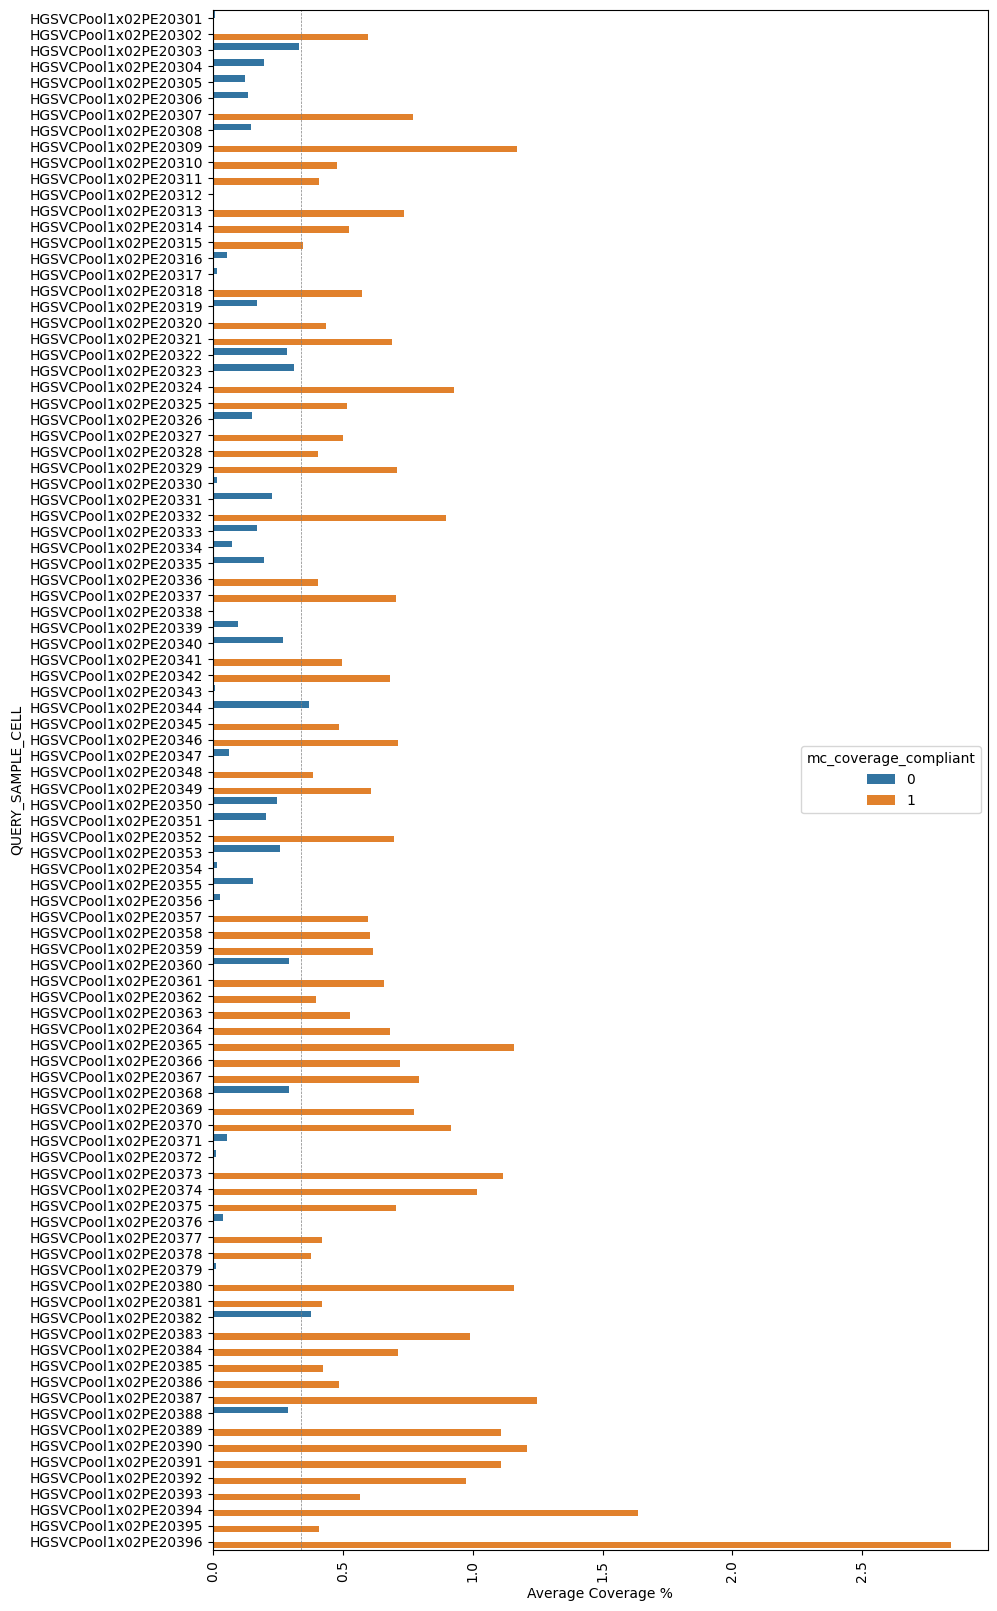

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm, Normalize


plt.style.use('default')
plt.figure(figsize=(10,20))


merge_df

ax = sns.barplot(data=merge_df.sort_values(by="QUERY_SAMPLE_CELL"),  y="QUERY_SAMPLE_CELL", x="Average_Coverage", hue="mc_coverage_compliant")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.axvline(0.34, ls="--", color="grey", lw=0.5)
ax.set_xlabel("Average Coverage %")

In [ ]:
merge_df.columns